In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
! pip install pydicom

     |████████████████████████████████| 7.1MB 2.8MB/s 


In [1]:
import numpy as np
import pandas as pd
import pydicom
import os
from os import listdir

from os.path import isfile, join
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

from math import ceil, floor, log
import cv2

import tensorflow as tf
import keras

import sys

# from keras_applications.resnet import ResNet50
from keras_applications.inception_v3 import InceptionV3

from sklearn.model_selection import ShuffleSplit
test_images_dir = '/content/drive/My Drive/Sample of Sampled Data/Test_Sample/'
train_images_dir = '/content/drive/My Drive/Sample of Sampled Data/'

Using TensorFlow backend.


In [0]:
def read_testset(filename="/content/drive/My Drive/Sample of Sampled Data/CSV Files/test_sample.csv"):
    df = pd.read_csv(filename)

    
    df = df.loc[:, ["Label", "Type", "ID_Image"]]
    df = df.set_index(['ID_Image', 'Type']).unstack(level=-1)
    
    return df

def read_trainset(filename="/content/drive/My Drive/Sample of Sampled Data/CSV Files/train_sample.csv"):
    df = pd.read_csv(filename)

    
    
    df = df.loc[:, ["Label", "Type", "ID_Image"]]
    df = df.set_index(['ID_Image', 'Type']).unstack(level=-1)
    
    return df

train_df = read_trainset()   
test_df = read_testset()

In [0]:
train_df.columns = train_df.columns.get_level_values(1)
test_df.columns = test_df.columns.get_level_values(1)

In [0]:
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

In [0]:
# train_df.head(10)

In [0]:
# # Images Example
# train_images = [f for f in listdir(train_images_dir) if isfile(join(train_images_dir, f))]
# test_images = [f for f in listdir(test_images_dir) if isfile(join(test_images_dir, f))]
# print('5 Training images', train_images[:5]) # Print the first 5

In [0]:
# train_images = [f for f in listdir(train_images_dir) if isfile(join(train_images_dir, f))]
# test_images = [f for f in listdir(test_images_dir) if isfile(join(test_images_dir, f))]

In [0]:
# for i in train_images[:1]:
#   dicom = pydicom.dcmread(train_images_dir + i)
#   print(dicom.pixel_array) 
#   print(dicom.pixel_array.shape)

In [0]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def sigmoid_window(dcm, window_center, window_width, U=1.0, eps=(1.0 / 255.0)):

    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)

    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    ue = np.log((U / eps) - 1.0)
    W = (2 / window_width) * ue
    b = ((-2 * window_center) / window_width) * ue
    z = W * img + b
    img = U / (1 + np.power(np.e, -1.0 * z))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

def all_channels_window(img):
    all_chan_img = np.zeros((img.shape[0], img.shape[1], 3))
    all_chan_img[:, :, 2] = np.clip(img, 0.0, 1.0)
    all_chan_img[:, :, 0] = np.clip(img - 1.0, 0.0, 1.0)
    all_chan_img[:, :, 1] = np.clip(img - 2.0, 0.0, 1.0)
    return all_chan_img

def bsb_window(dcm):
    brain_img = sigmoid_window(dcm, 40, 80)
    subdural_img = sigmoid_window(dcm, 80, 200)
    soft_img = sigmoid_window(dcm, 40, 380)
    
    combo = (brain_img*0.3 + subdural_img*0.5 + soft_img*0.2)

    return all_channels_window(combo)

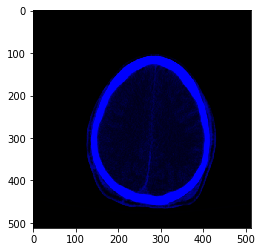

In [9]:
dcm = pydicom.dcmread(train_images_dir+train_images[2])
brain_img = sigmoid_window(dcm, 40, 80)
subdural_img = sigmoid_window(dcm, 80, 200)
soft_img = sigmoid_window(dcm, 40, 380)

combo = (brain_img*0.3 + subdural_img*0.5 + soft_img*0.2)

all_chan_img = np.zeros((combo.shape[0], combo.shape[1], 3))
all_chan_img[:, :, 2] = np.clip(combo, 0.0, 1.0)
all_chan_img[:, :, 0] = np.clip(combo - 1.0, 0.0, 1.0)
all_chan_img[:, :, 1] = np.clip(combo - 2.0, 0.0, 1.0)

plt.imshow(all_chan_img, cmap=plt.cm.bone)

In [0]:
def window_with_correction(dcm, window_center, window_width):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def window_without_correction(dcm, window_center, window_width):
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img
def window_testing(img, window):
    brain_img = window(img, 40, 80)
    subdural_img = window(img, 80, 200)
    soft_img = window(img, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img



In [0]:
# non = train_df[train_df['any'] == 0]['ID_Image'].iloc[1]
# epidural = train_df[train_df['epidural'] == 1]['ID_Image'].iloc[1]
# intraparenchymal = train_df[train_df['intraparenchymal'] == 1]['ID_Image'].iloc[1]
# intraventricular = train_df[train_df['intraventricular'] == 1]['ID_Image'].iloc[1]
# subarachnoid = train_df[train_df['subarachnoid'] == 1]['ID_Image'].iloc[1]
# subdural = train_df[train_df['subdural'] == 1]['ID_Image'].iloc[1]

# # example of a "bad data point" (i.e. (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100) == True)
# dicom_non = pydicom.dcmread(train_images_dir + non + ".dcm")
# dicom_epidural = pydicom.dcmread(train_images_dir + epidural + ".dcm")
# dicom_intraparenchymal = pydicom.dcmread(train_images_dir + intraparenchymal + ".dcm")
# dicom_intraventricular = pydicom.dcmread(train_images_dir + intraventricular + ".dcm")
# dicom_subarachnoid = pydicom.dcmread(train_images_dir + subarachnoid + ".dcm")
# dicom_subdural = pydicom.dcmread(train_images_dir + subdural + ".dcm")

In [0]:
# for i in [dicom_non, dicom_epidural, dicom_intraparenchymal, dicom_intraventricular, dicom_subarachnoid, dicom_subdural]:
#   brain_img = window_image(i, 40, 80)
#   subdural_img = window_image(i, 80, 200)
#   soft_img = window_image(i, 40, 380)
#   brain_img_1 = (brain_img - 0) / 80
#   subdural_img_1 = (subdural_img - (-20)) / 200
#   soft_img_1 = (soft_img - (-150)) / 380
#   bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
#   plt.imshow(bsb_img, cmap=plt.cm.bone)

In [0]:
def _read(path, desired_size):
    """Will be used in DataGenerator"""
    
    dcm = pydicom.dcmread(path)
    
    try:
        img = bsb_window(dcm)
    except:
        img = np.zeros(desired_size)
    
    
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    return img

In [0]:
#_read(train_images_dir+'ID_5c8b5d701'+'.dcm', (128, 128))

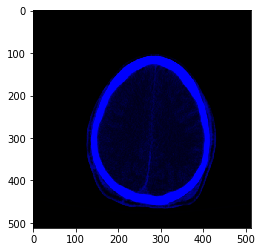

In [13]:
dcm = pydicom.dcmread(train_images_dir+train_images[2])
img = bsb_window(dcm)
plt.imshow(img, cmap=plt.cm.bone)

In [0]:
train_images = [f for f in listdir(train_images_dir) if isfile(join(train_images_dir, f))]
test_images = [f for f in listdir(test_images_dir) if isfile(join(test_images_dir, f))]

In [0]:
train_images_ID = [s.strip('.dcm') for s in train_images]
test_images_ID = [s.strip('.dcm') for s in test_images]

In [16]:
p_train = []
a = 0
for i in train_images:
  a += 1
  print(a)
  dicom = _read(train_images_dir+i, (128, 128)) 
  p_train.append(dicom)
p_test = []
a = 0
for i in test_images:
  a += 1
  print(a)
  dicom = _read(test_images_dir+i, (128, 128)) 
  p_test.append(dicom)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in power


5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725
5726
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


6593
6594
6595
6596
6597
6598
6599
6600
6601
6602
6603
6604
6605
6606
6607
6608
6609
6610
6611
6612
6613
6614
6615
6616
6617
6618
6619
6620
6621
6622
6623
6624
6625
6626
6627
6628
6629
6630
6631
6632
6633
6634
6635
6636
6637
6638
6639
6640
6641
6642
6643
6644
6645
6646
6647
6648
6649
6650
6651
6652
6653
6654
6655
6656
6657
6658
6659
6660
6661
6662
6663
6664
6665
6666
6667
6668
6669
6670
6671
6672
6673
6674
6675
6676
6677
6678
6679
6680
6681
6682
6683
6684
6685
6686
6687
6688
6689
6690
6691
6692
6693
6694
6695
6696
6697
6698
6699
6700
6701
6702
6703
6704
6705
6706
6707
6708
6709
6710
6711
6712
6713
6714
6715
6716
6717
6718
6719
6720
6721
6722
6723
6724
6725
6726
6727
6728
6729
6730
6731
6732
6733
6734
6735
6736
6737
6738
6739
6740
6741
6742
6743
6744
6745
6746
6747
6748
6749
6750
6751
6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792


In [0]:
# len(p_test)

In [0]:
# len(test_images_ID)

In [0]:
l_train =  list(zip(train_images_ID, p_train))
train_pixel = pd.DataFrame(l_train, columns = ['ID_Image' , 'pixel']) 
l_test =  list(zip(test_images_ID, p_test))
test_pixel = pd.DataFrame(l_test, columns = ['ID_Image' , 'pixel']) 

In [0]:
train_merge = train_df.merge(train_pixel, left_on='ID_Image', right_on='ID_Image', how='inner')
test_merge = test_df.merge(test_pixel, left_on='ID_Image', right_on='ID_Image', how='inner')

In [0]:
test_merge.columns

Index(['ID_Image', 'any', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural', 'pixel'],
      dtype='object')

In [0]:
train_X = train_merge.drop(columns = ['ID_Image','any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural'])
train_X = np.stack(train_X['pixel'].tolist(),axis=0)
train_Y = np.array(train_merge[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']])
test_X = test_merge.drop(columns = ['ID_Image','any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural'])
test_X = np.stack(test_X['pixel'].tolist(),axis=0)
test_Y = np.array(test_merge[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']])


In [0]:
print('Training Set X Shape:', train_X.shape)
print('Training Set Y Shape:', train_Y.shape)
print('Testing Set X Shape:', test_X.shape)
print('Testing Set Y Shape:', test_Y.shape)

Training Set X Shape: (6382, 128, 128, 3)
Training Set Y Shape: (6382, 6)
Testing Set X Shape: (1102, 128, 128, 3)
Testing Set Y Shape: (1102, 6)


In [0]:
import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

In [0]:
from keras import backend as K

def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)
def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)

def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)

def weighted_log_loss_metric(trues, preds):
    """
    Will be used to calculate the log loss 
    of the validation set in PredictionCheckpoint()
    ------------------------------------------
    """
    class_weights = [2., 1., 1., 1., 1., 1.]
    
    epsilon = 1e-7
    
    preds = np.clip(preds, epsilon, 1-epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)

    return - loss_samples.mean()

In [22]:
cnn_model = Sequential()
# Convolutional Layer 1:
cnn_model.add(Conv2D(32, kernel_size = (3, 3), activation = 'linear', input_shape = (128, 128, 3), padding = 'same'))
cnn_model.add(LeakyReLU(alpha = 0.1))
# Max Pooling Layer 1:
cnn_model.add(MaxPooling2D((2, 2),padding = 'same'))
# Convolutional Layer 2:
cnn_model.add(Conv2D(64, kernel_size = (3, 3), activation = 'linear', padding = 'same'))
cnn_model.add(LeakyReLU(alpha = 0.1))
# Max Pooling Layer 2:
cnn_model.add(MaxPooling2D((2, 2),padding = 'same'))
# Convolutional Layer 3:
cnn_model.add(Conv2D(128, kernel_size = (3, 3), activation = 'linear', padding = 'same'))
cnn_model.add(LeakyReLU(alpha = 0.1))
# Max Pooling Layer 3:
cnn_model.add(MaxPooling2D((2, 2),padding = 'same'))
# Flatten Preprocessing:
cnn_model.add(Flatten())
# Fully Connected Layer (Dense Layer):
cnn_model.add(Dense(128, activation = 'linear'))
cnn_model.add(LeakyReLU(alpha = 0.1))
# Output Layer (Dense Layer):
cnn_model.add(Dense(6, activation = 'sigmoid')) # choose one of them? # softmax

# Compile CNN model
cnn_model.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.Adam(), metrics = [weighted_loss])
cnn_model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
____________________

In [23]:
datagen = ImageDataGenerator(
    rotation_range = 30,
    horizontal_flip = True)
datagen.fit(train_X)

# Fits the model on batches with real-time data augmentation:
cnn_model_process = cnn_model.fit_generator(datagen.flow(train_X, train_Y, batch_size = 32),
                                                            steps_per_epoch = len(train_X) / 32, 
                                                            epochs = 20, verbose = 1, validation_data = (test_X, test_Y))
# cnn_model_process = cnn_model.fit(train_X, train_Y, batch_size = 32, epochs = 20, verbose = 1, validation_data = (test_X, test_Y))




Epoch 1/20





200/199 [==============================] - 24s 119ms/step - loss: 3.4531 - weighted_loss: 3.3101 - val_loss: 12.8634 - val_weighted_loss: 12.1914
Epoch 2/20
 44/199 [=====>........................] - ETA: 11s - loss: 12.7426 - weighted_loss: 12.0432

KeyboardInterrupt: ignored

In [0]:
# cnn_model_process.history

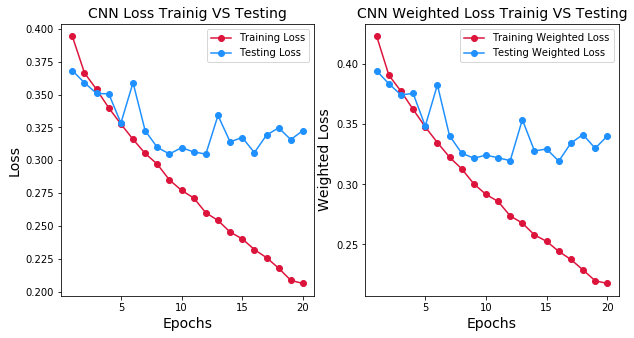

In [0]:
# fig, axes = plt.subplots(1, 2, figsize = (10, 5))
# axes[0].plot(range(1, len(cnn_model_process.history['loss']) + 1), cnn_model_process.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
# axes[0].plot(range(1, len(cnn_model_process.history['val_loss']) + 1), cnn_model_process.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
# axes[0].set_xlabel('Epochs', fontsize = 14)
# axes[0].set_ylabel('Loss',fontsize = 14)
# axes[0].set_title('CNN Loss Trainig VS Testing', fontsize = 14)
# axes[0].legend(loc = 'best')
# axes[1].plot(range(1, len(cnn_model_process.history['weighted_loss']) + 1), cnn_model_process.history['weighted_loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Weighted Loss')
# axes[1].plot(range(1, len(cnn_model_process.history['val_weighted_loss']) + 1), cnn_model_process.history['val_weighted_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Weighted Loss')
# axes[1].set_xlabel('Epochs', fontsize = 14)
# axes[1].set_ylabel('Weighted Loss',fontsize = 14)
# axes[1].set_title('CNN Weighted Loss Trainig VS Testing', fontsize = 14)
# axes[1].legend(loc = 'best')

In [0]:

cnn_model_dropout = Sequential()
# Convolutional Layer 1:
cnn_model_dropout.add(Conv2D(32, kernel_size = (3, 3), activation = 'linear', input_shape = (128, 128, 3), padding = 'same'))
cnn_model_dropout.add(LeakyReLU(alpha = 0.1))
# Max Pooling Layer 1:
cnn_model_dropout.add(MaxPooling2D((2, 2),padding = 'same'))
# Convolutional Layer 2:
cnn_model_dropout.add(Conv2D(64, kernel_size = (3, 3), activation = 'linear', padding = 'same'))
cnn_model_dropout.add(LeakyReLU(alpha = 0.1))
# Max Pooling Layer 2:
cnn_model_dropout.add(MaxPooling2D((2, 2),padding = 'same'))
# Convolutional Layer 3:
cnn_model_dropout.add(Conv2D(128, kernel_size = (3, 3), activation = 'linear', padding = 'same'))
cnn_model_dropout.add(LeakyReLU(alpha = 0.1))
# Max Pooling Layer 3:
cnn_model_dropout.add(MaxPooling2D((2, 2),padding = 'same'))
# Flatten Preprocessing:
cnn_model_dropout.add(Flatten())
# Fully Connected Layer (Dense Layer):
cnn_model_dropout.add(Dense(128, activation = 'linear'))
cnn_model_dropout.add(BatchNormalization())
cnn_model_dropout.add(LeakyReLU(alpha = 0.1))

# Dropout Layer 4:
cnn_model_dropout.add(Dropout(0.3))
# Output Layer (Dense Layer):
cnn_model_dropout.add(Dense(6, activation = 'sigmoid'))

# Compile CNN model
sgd = keras.optimizers.SGD(lr = 0.005, decay = 1e-6, momentum = 0.8, nesterov = True)
cnn_model_dropout.compile(loss = "binary_crossentropy", optimizer = sgd, metrics = [weighted_loss])
cnn_model_dropout.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)      

In [0]:
datagen = ImageDataGenerator(
    rotation_range = 30,
    horizontal_flip = True)
datagen.fit(train_X)

# Fits the model on batches with real-time data augmentation:
cnn_model_dropout_process = cnn_model_dropout.fit_generator(datagen.flow(train_X, train_Y, batch_size = 16),
                                                            steps_per_epoch = len(train_X) / 16, 
                                                            epochs = 30, verbose = 1, validation_data = (test_X, test_Y))
# cnn_model_dropout_process = cnn_model_dropout.fit(train_X, train_Y, batch_size = 32, epochs = 20, verbose = 1, validation_data = (test_X, test_Y))

Epoch 1/30
399/398 [==============================] - 19s 48ms/step - loss: 0.4573 - weighted_loss: 0.4769 - val_loss: 0.3966 - val_weighted_loss: 0.4282
Epoch 2/30
399/398 [==============================] - 18s 46ms/step - loss: 0.3815 - weighted_loss: 0.4059 - val_loss: 0.3889 - val_weighted_loss: 0.4117
Epoch 3/30
399/398 [==============================] - 18s 46ms/step - loss: 0.3656 - weighted_loss: 0.3892 - val_loss: 0.4827 - val_weighted_loss: 0.5440
Epoch 4/30
399/398 [==============================] - 18s 46ms/step - loss: 0.3551 - weighted_loss: 0.3796 - val_loss: 0.3946 - val_weighted_loss: 0.4247
Epoch 5/30
399/398 [==============================] - 19s 47ms/step - loss: 0.3466 - weighted_loss: 0.3692 - val_loss: 0.3878 - val_weighted_loss: 0.4117
Epoch 6/30
399/398 [==============================] - 18s 46ms/step - loss: 0.3412 - weighted_loss: 0.3635 - val_loss: 0.3419 - val_weighted_loss: 0.3643
Epoch 7/30
399/398 [==============================] - 19s 47ms/step - loss: 

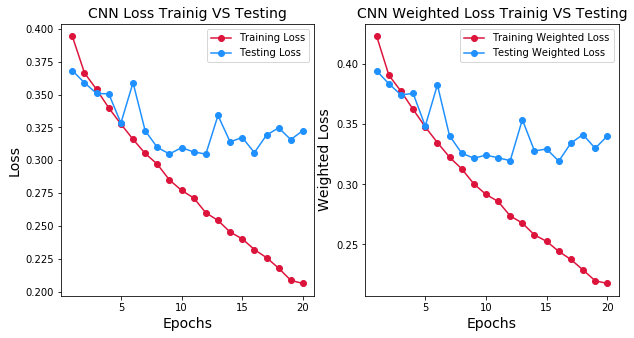

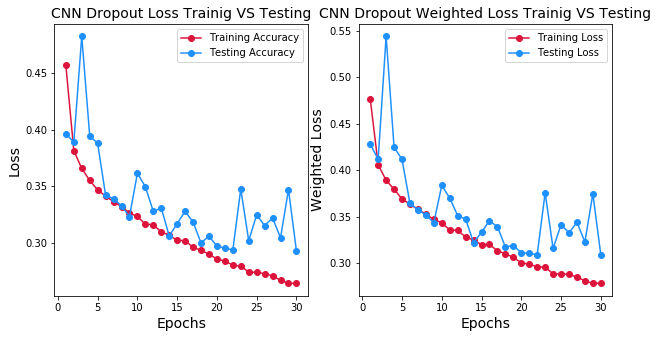

In [0]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(cnn_model_process.history['loss']) + 1), cnn_model_process.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[0].plot(range(1, len(cnn_model_process.history['val_loss']) + 1), cnn_model_process.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Loss',fontsize = 14)
axes[0].set_title('CNN Loss Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(cnn_model_process.history['weighted_loss']) + 1), cnn_model_process.history['weighted_loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Weighted Loss')
axes[1].plot(range(1, len(cnn_model_process.history['val_weighted_loss']) + 1), cnn_model_process.history['val_weighted_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Weighted Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Weighted Loss',fontsize = 14)
axes[1].set_title('CNN Weighted Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(cnn_model_dropout_process.history['loss']) + 1), cnn_model_dropout_process.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(cnn_model_dropout_process.history['val_loss']) + 1), cnn_model_dropout_process.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Loss',fontsize = 14)
axes[0].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(cnn_model_dropout_process.history['weighted_loss']) + 1), cnn_model_dropout_process.history['weighted_loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(cnn_model_dropout_process.history['val_weighted_loss']) + 1), cnn_model_dropout_process.history['val_weighted_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Weighted Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Weighted Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

In [0]:
# class DataGenerator(keras.utils.Sequence):

#     def __init__(self, list_IDs, labels=None, batch_size=1, img_size=(512, 512, 1), 
#                  img_dir=train_images_dir, *args, **kwargs):

#         self.list_IDs = list_IDs
#         self.labels = labels
#         self.batch_size = batch_size
#         self.img_size = img_size
#         self.img_dir = img_dir
#         self.on_epoch_end()

#     def __len__(self):
#         return int(ceil(len(self.indices) / self.batch_size))
#     def __getitem__(self, index):
#         indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
#         list_IDs_temp = [self.list_IDs[k] for k in indices]
        
#         if self.labels is not None:
#             X, Y = self.__data_generation(list_IDs_temp)
#             return X, Y
#         else:
#             X = self.__data_generation(list_IDs_temp)
#             return X
#     def on_epoch_end(self):
        
        
#         if self.labels is not None: # for training phase we undersample and shuffle
#             # keep probability of any=0 and any=1
#             keep_prob = self.labels.iloc[:, 0].map({0: 0.35, 1: 0.5})
#             keep = (keep_prob > np.random.rand(len(keep_prob)))
#             self.indices = np.arange(len(self.list_IDs))[keep]
#             np.random.shuffle(self.indices)
#         else:
#             self.indices = np.arange(len(self.list_IDs))
#     def __data_generation(self, list_IDs_temp):
#         X = np.empty((self.batch_size, *self.img_size))
        
#         if self.labels is not None: # training phase
#             Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
#             for i, ID in enumerate(list_IDs_temp):
#                 X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
#                 Y[i,] = self.labels.loc[ID].values
        
#             return X, Y
        
#         else: # test phase
#             for i, ID in enumerate(list_IDs_temp):
#                 X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            
#             return X


In [0]:
# from keras import backend as K

# def weighted_log_loss(y_true, y_pred):
#     """
#     Can be used as the loss function in model.compile()
#     ---------------------------------------------------
#     """
    
#     class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
#     eps = K.epsilon()
    
#     y_pred = K.clip(y_pred, eps, 1.0-eps)

#     out = -(         y_true  * K.log(      y_pred) * class_weights
#             + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
#     return K.mean(out, axis=-1)
# def _normalized_weighted_average(arr, weights=None):
#     """
#     A simple Keras implementation that mimics that of 
#     numpy.average(), specifically for this competition
#     """
    
#     if weights is not None:
#         scl = K.sum(weights)
#         weights = K.expand_dims(weights, axis=1)
#         return K.sum(K.dot(arr, weights), axis=1) / scl
#     return K.mean(arr, axis=1)

# def weighted_loss(y_true, y_pred):
#     """
#     Will be used as the metric in model.compile()
#     ---------------------------------------------
    
#     Similar to the custom loss function 'weighted_log_loss()' above
#     but with normalized weights, which should be very similar 
#     to the official competition metric:
#         https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
#     and hence:
#         sklearn.metrics.log_loss with sample weights
#     """
    
#     class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
#     eps = K.epsilon()
    
#     y_pred = K.clip(y_pred, eps, 1.0-eps)

#     loss = -(        y_true  * K.log(      y_pred)
#             + (1.0 - y_true) * K.log(1.0 - y_pred))
    
#     loss_samples = _normalized_weighted_average(loss, class_weights)
    
#     return K.mean(loss_samples)

# def weighted_log_loss_metric(trues, preds):
#     """
#     Will be used to calculate the log loss 
#     of the validation set in PredictionCheckpoint()
#     ------------------------------------------
#     """
#     class_weights = [2., 1., 1., 1., 1., 1.]
    
#     epsilon = 1e-7
    
#     preds = np.clip(preds, epsilon, 1-epsilon)
#     loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
#     loss_samples = np.average(loss, axis=1, weights=class_weights)

#     return - loss_samples.mean()